In [7]:
import numpy as np
import pandas as pd
from gnews import GNews
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
def extract_economic_news(language='fr', max_results=50, period='7d', topic='ECONOMY'):
    google_news = GNews(language=language, max_results=max_results, period=period)
    news = google_news.get_news_by_topic(topic)
    title_news = [article['title'] for article in news]
    return news,title_news

def align_with_index(df1, df2, date_col='Date', join_type='inner'):
    """
    Align datasets using pandas align method.
    join_type: 'inner', 'outer', 'left', 'right'
    """
    # Set date as index
    df1_indexed = df1.set_index(pd.to_datetime(df1[date_col], format='%d/%m/%Y'))
    df2_indexed = df2.set_index(pd.to_datetime(df2[date_col], format='%d/%m/%Y'))
    
    # Align the dataframes
    df1_aligned, df2_aligned = df1_indexed.align(df2_indexed, join=join_type, axis=0)
    
    return df1_aligned, df2_aligned


In [39]:
df_oat = pd.read_csv("Rendement de l'Obligation France 10 ans - Données Historiques (1).csv")
df_bund = pd.read_csv("Rendement de l'Obligation Allemagne 10 ans - Données Historiques.csv")
df_oat_aligned, df_bund_aligned = align_with_index(df_oat, df_bund, date_col='Date', join_type='inner')
df_oat_aligned['Dernier'] = df_oat_aligned['Dernier'].str.replace(',', '.').astype(float)
df_bund_aligned['Dernier'] = df_bund_aligned['Dernier'].str.replace(',', '.').astype(float)
y = df_oat_aligned['Dernier']/df_bund_aligned['Dernier']
y.sort_index(inplace=True)

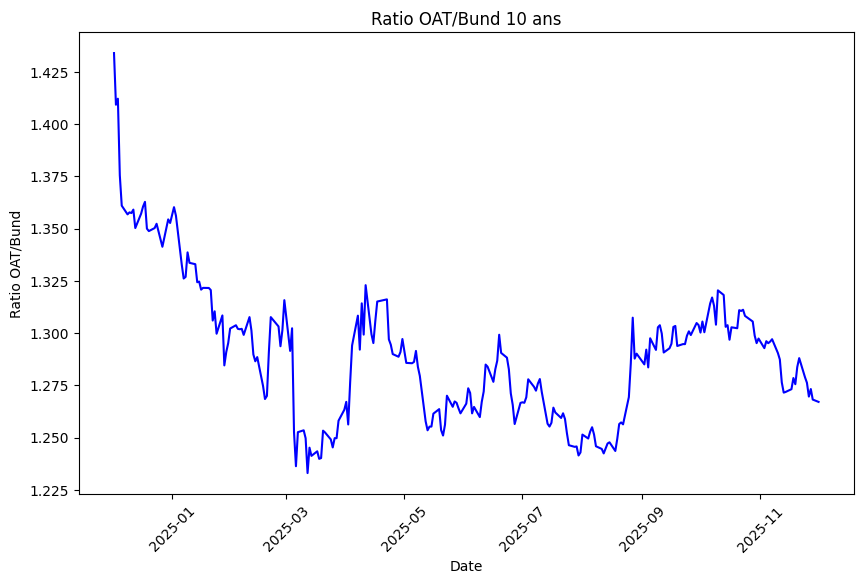

In [50]:
start_date = '2024-12-01'
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y[start_date:], label='Ratio OAT/Bund 10 ans', color='blue')
ax.set_title("Ratio OAT/Bund 10 ans")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio OAT/Bund")
plt.xticks(rotation=45)
plt.show()

Fitting an ARMA process on the ratio to give the 'basic prediction'.

In [51]:
#import adf test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(y[start_date:])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -2.7002401806237977
p-value: 0.07399671652308822


In [82]:
spread_one_year = y[:numbers_of_points]
spread_one_year_diff = spread_one_year.diff().dropna()

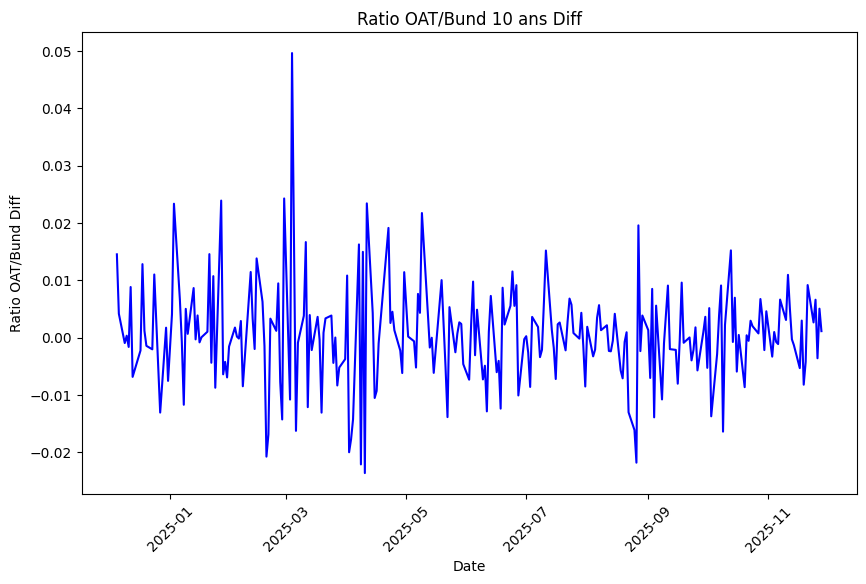

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_oat_aligned['Date'][1:numbers_of_points], spread_one_year_diff, label='Ratio OAT/Bund 10 ans Diff', color='blue')
ax.set_title("Ratio OAT/Bund 10 ans Diff")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio OAT/Bund Diff")
plt.xticks(rotation=45)
plt.show()

In [84]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread_one_year_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -6.6580510123087375
p-value: 4.926735330871125e-09


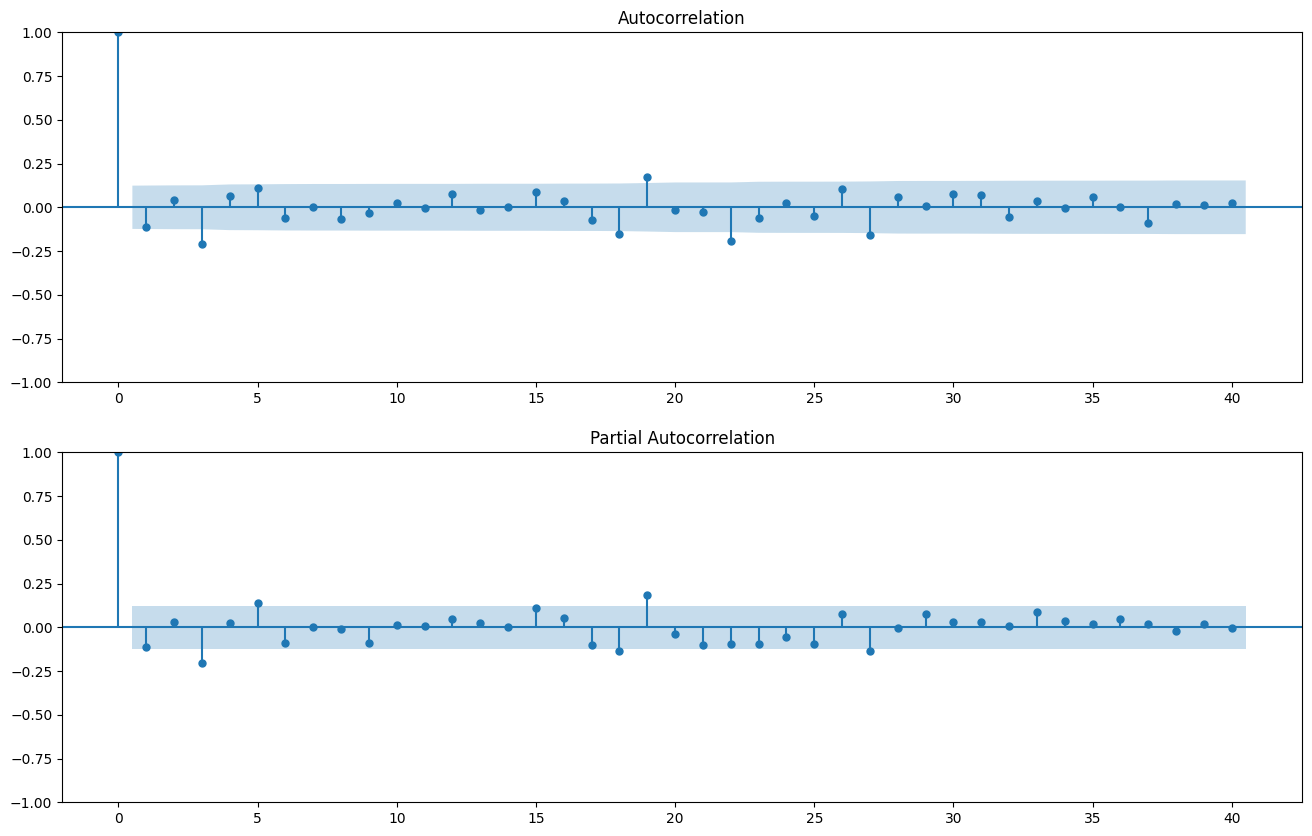

In [85]:
#Plotting pcf and acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(16,10))
plot_acf(spread_one_year_diff, ax=ax[0], lags=40)
plot_pacf(spread_one_year_diff, ax=ax[1], lags=40)
plt.show()

In [86]:
# p = 3, q=3
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(spread_one_year, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Dernier   No. Observations:                  252
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 839.882
Date:                Tue, 02 Dec 2025   AIC                          -1665.764
Time:                        10:53:40   BIC                          -1641.086
Sample:                             0   HQIC                         -1655.833
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3990      0.254     -1.568      0.117      -0.898       0.100
ar.L2         -0.4415      0.252     -1.751      0.080      -0.936       0.053
ar.L3         -0.1012      0.223     -0.453      0.6

In [52]:
french_economy, french_title = extract_economic_news(max_results=70)
german_economy, german_title = extract_economic_news(language='de')

In [54]:
french_title

["« Récession », « krach boursier » : le scénario noir pour l'économie américaine en cas d'annexion du Groenland - La Tribune",
 'Wall Street pas convaincue par une nouvelle salve de données économiques - Boursorama',
 'Salaires : avec le ralentissement de l’inflation, les grandes entreprises délaissent les augmentations collectives - Le Monde.fr',
 "Où sont placés les 6.600 milliards d'épargne des Français ? - Les Echos",
 'Demande en baisse, forte concurrence internationale... Le verrier Arc enferré dans une restructuration permanente - Le Figaro',
 "Venezuela : derrière le pétrole, le retour à une hégémonie du dollar - L'Humanité",
 "Crise agricole : désabusé depuis les actions de 2024, Benoît n'a pas rejoint la mobilisation cette année - France 3 Régions",
 'Inflation à 42%, monnaie en chute libre… Que se passe-t-il en Iran ? - BFM',
 'Immobilier 2026 : top 3 des villes où la demande explose (les acheteurs ont tranché) - PAP',
 "L'inflation en zone euro revient à 2% en décembre, da

Récupération des données macroéconomiques...
✓ FR_Inflation_CPI
✓ FR_PIB
✓ FR_Unemployment_Rate
✓ FR_Debt_Rate
✓ DE_Inflation_CPI
✓ DE_PIB_Growth
✓ DE_Unemployment_Rate
✓ DE_Debt_Rate

Données récupérées: 70 observations
Période: 2020-01-01 à 2025-10-01


📊 ANALYSE STATISTIQUE 2025

Nombre d'observations en 2021: 12

------------------------------------------------------------
STATISTIQUES DESCRIPTIVES 2021
------------------------------------------------------------
       FR_Inflation_CPI       FR_PIB  FR_Unemployment_Rate  FR_Debt_Rate  \
count            1.0000       4.0000               12.0000         1.000   
mean             1.6423  555790.9000                7.8667       112.703   
std                 NaN   12641.9909                0.2902           NaN   
min              1.6423  541876.0000                7.4000       112.703   
25%              1.6423  546785.5000                7.6500       112.703   
50%              1.6423  556634.1000                7.9000       112.703

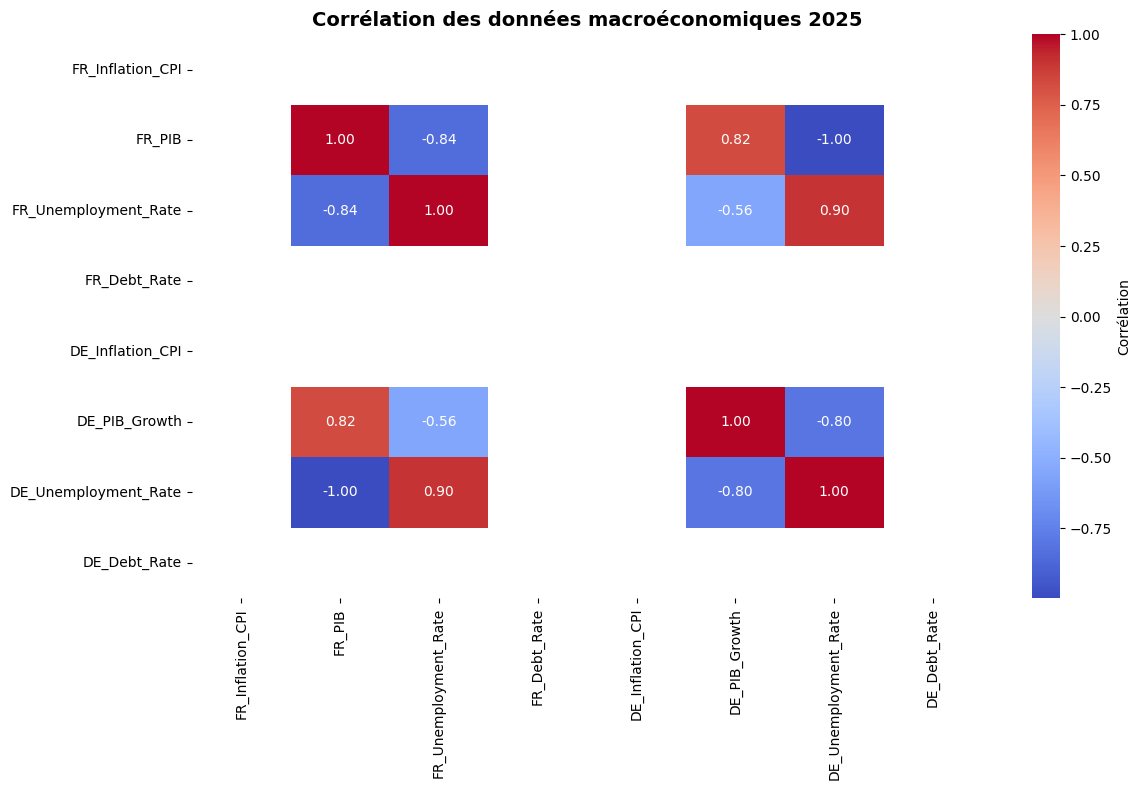



Génération des visualisations...


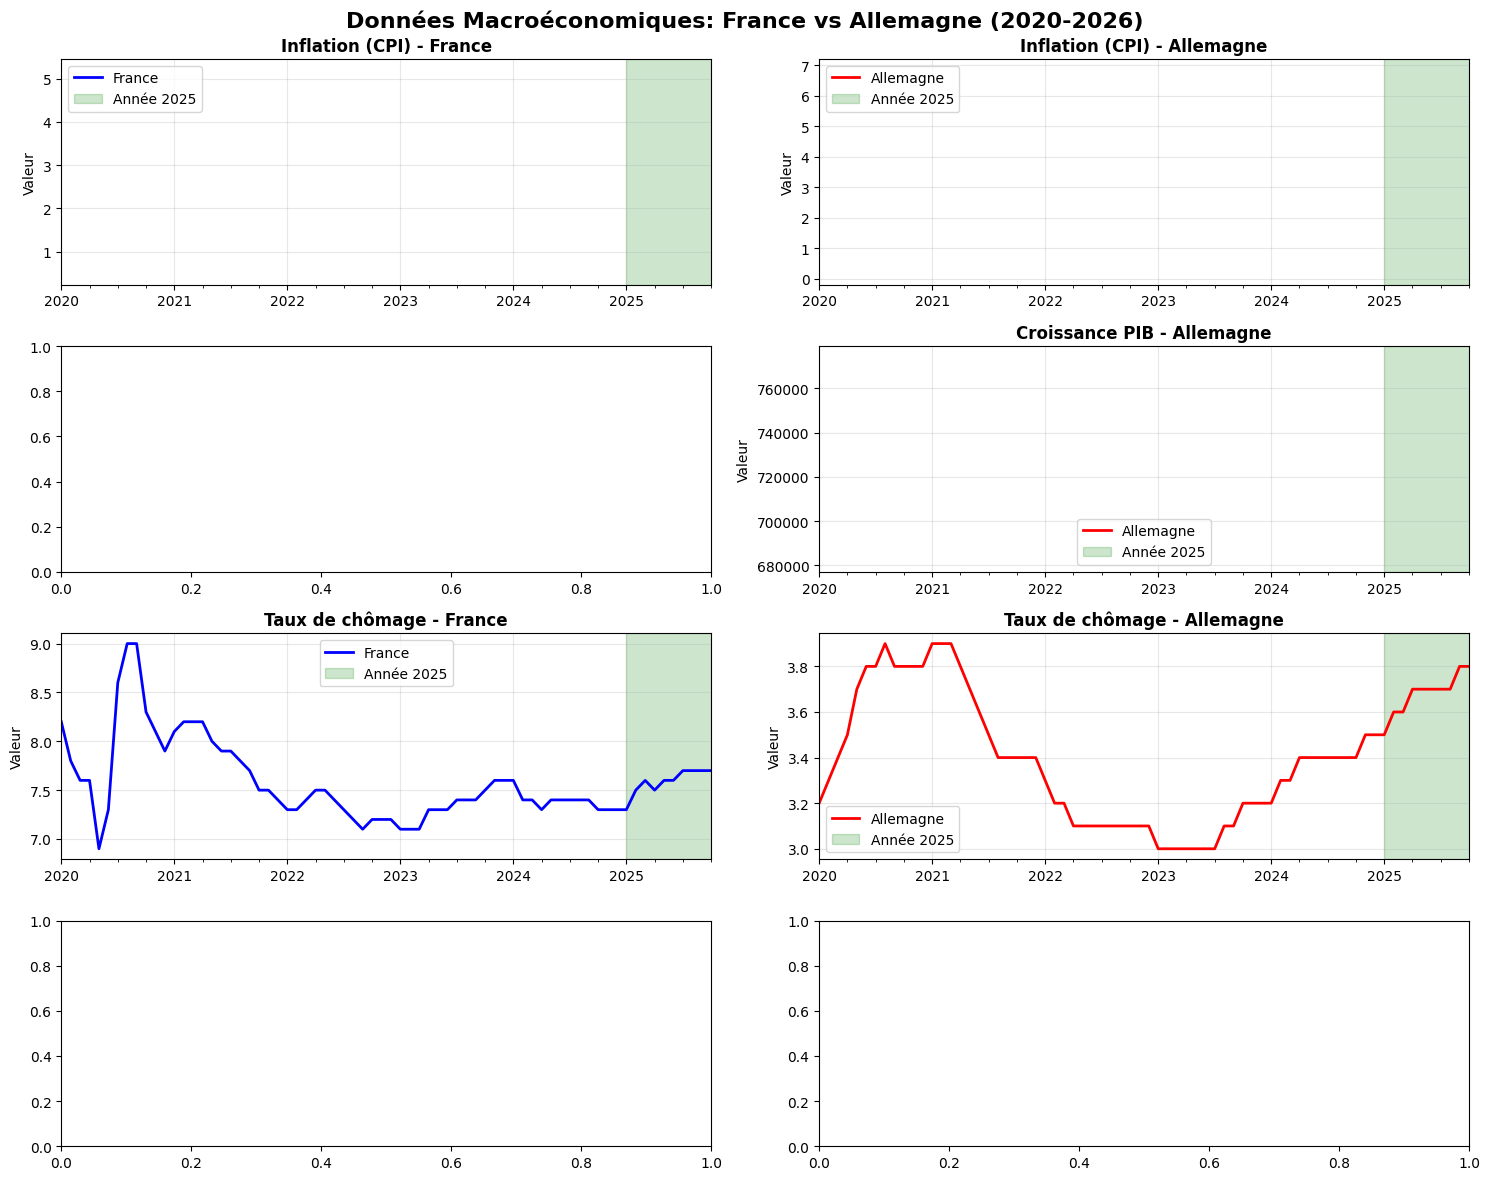

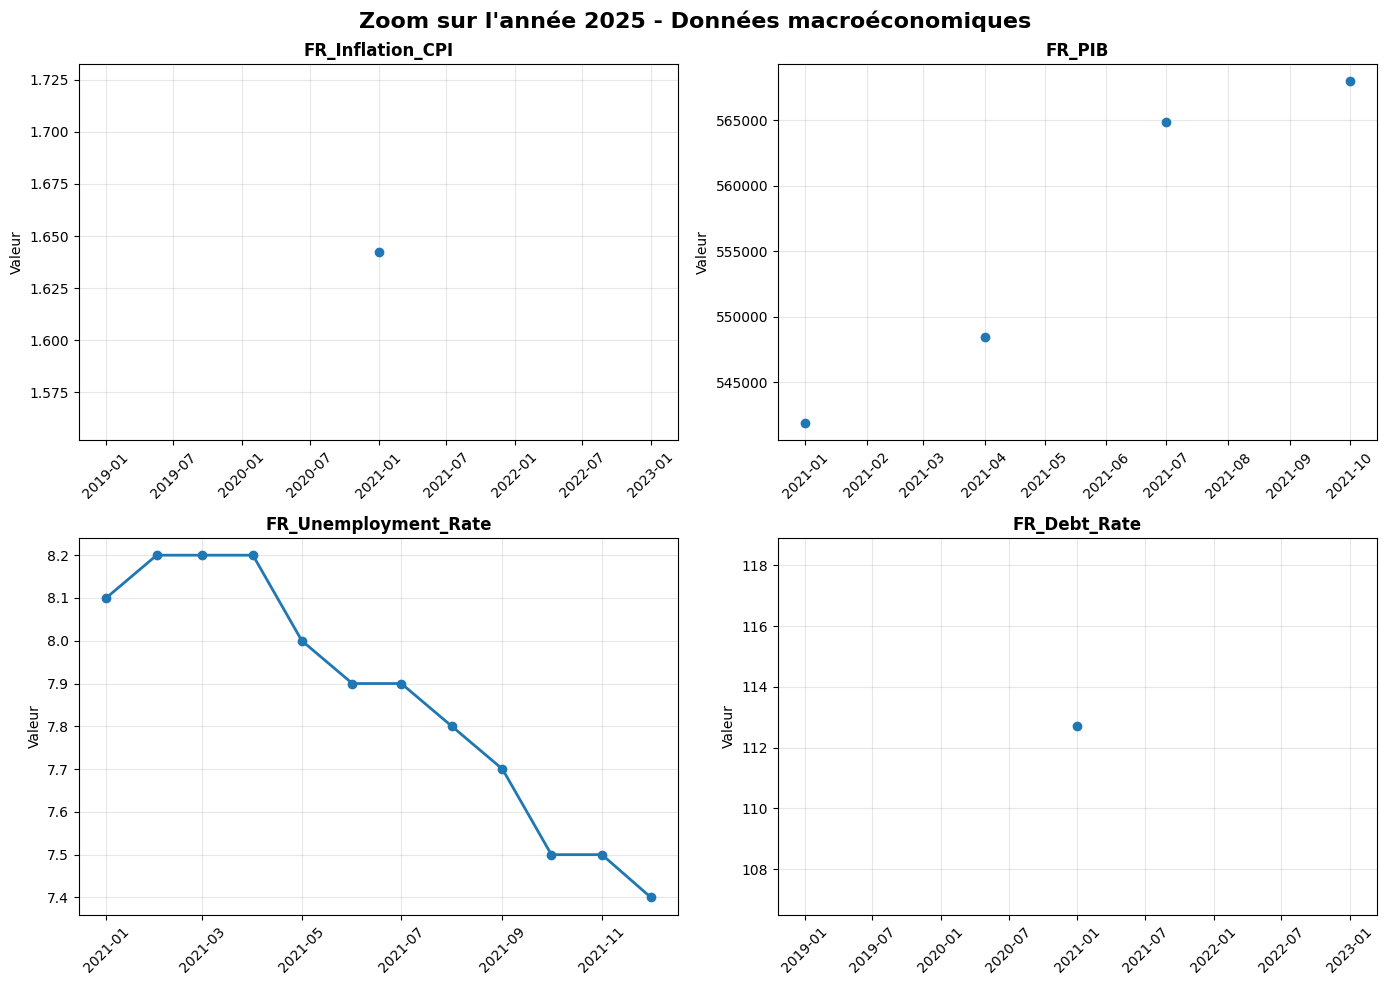


✓ Visualisations sauvegardées:
  - macro_timeseries_comparison.png
  - macro_correlation_2025.png
  - macro_2025_zoom.png

✓ Données exportées:
  - macro_data_2020_2026.csv
  - macro_data_2021.csv

✓ Analyse terminée!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from fredapi import Fred
import warnings
warnings.filterwarnings('ignore')

# Configuration
START_DATE = '2020-01-01'
END_DATE = '2026-01-08'
ANALYSIS_YEAR = '2025'

# Initialiser l'API FRED (nécessite une clé API gratuite)
# Obtenir la clé: https://fred.stlouisfed.org/docs/api/api-key.html
FRED_API_KEY = 'c1d79a456b2cc144c9132a39f0865cd8'
fred = Fred(api_key=FRED_API_KEY)

# ===== RÉCUPÉRATION DES DONNÉES =====

def fetch_fred_data(series_id, label):
    """Récupère les données depuis FRED"""
    try:
        data = fred.get_series(series_id, observation_start=START_DATE, observation_end=END_DATE)
        return pd.DataFrame({label: data})
    except Exception as e:
        print(f"Erreur pour {label}: {e}")
        return None

# Dictionnaire des séries FRED pour France et Allemagne
# Format: 'serie_id': 'Label'
series_dict = {
    # France - Inflation (IPCH)
    'FPCPITOTLZGFRA': 'FR_Inflation_CPI',
    
    # France - PIB
    'CLVMNACSCAB1GQFR': 'FR_PIB',
    
    # France - Taux de chômage
    'LRHUTTTTFRM156S': 'FR_Unemployment_Rate',
    
    # France - Taux de dette publique (M3)
    'GGGDTAFRA188N': 'FR_Debt_Rate',
    
    # Allemagne - Inflation
    'FPCPITOTLZGDEU': 'DE_Inflation_CPI',
    
    # Allemagne - PIB
    'CLVMNACSCAB1GQDE': 'DE_PIB_Growth',
    
    # Allemagne - Taux de chômage
    'LRHUTTTTDEM156S': 'DE_Unemployment_Rate',
    
    # Allemagne - Taux de dette publique
    'GGGDTADEA188N': 'DE_Debt_Rate',
}

print("Récupération des données macroéconomiques...")
print("=" * 60)

data_frames = []
for series_id, label in series_dict.items():
    df = fetch_fred_data(series_id, label)
    if df is not None:
        data_frames.append(df)
        print(f"✓ {label}")
    else:
        print(f"✗ {label}")

# Fusionner tous les dataframes
if data_frames:
    macro_data = pd.concat(data_frames, axis=1)
    macro_data.index = pd.to_datetime(macro_data.index)
    macro_data.sort_index(inplace=True)
    print("\n" + "=" * 60)
    print(f"Données récupérées: {macro_data.shape[0]} observations")
    print(f"Période: {macro_data.index[0].date()} à {macro_data.index[-1].date()}")
    print("=" * 60)
else:
    print("Erreur: Aucune donnée n'a pu être récupérée")
    exit()

# ===== ANALYSE STATISTIQUE =====

print("\n\n📊 ANALYSE STATISTIQUE 2025")
print("=" * 60)

# Filtrer les données pour l'année 2021
data_2021 = macro_data.loc[macro_data.index.year == 2021].copy()

if len(data_2021) > 0:
    print(f"\nNombre d'observations en 2021: {len(data_2021)}")
    print("\n" + "-" * 60)
    print("STATISTIQUES DESCRIPTIVES 2021")
    print("-" * 60)
    
    stats_2021 = data_2021.describe().round(4)
    print(stats_2021)
    
    # Statistiques personnalisées
    print("\n" + "-" * 60)
    print("STATISTIQUES SUPPLÉMENTAIRES 2021")
    print("-" * 60)
    
    for col in data_2021.columns:
        if data_2021[col].notna().sum() > 0:
            print(f"\n{col}:")
            print(f"  Moyenne:       {data_2021[col].mean():.4f}")
            print(f"  Médiane:       {data_2021[col].median():.4f}")
            print(f"  Std Dev:       {data_2021[col].std():.4f}")
            print(f"  Min:           {data_2021[col].min():.4f}")
            print(f"  Max:           {data_2021[col].max():.4f}")
            print(f"  Asymétrie:     {data_2021[col].skew():.4f}")
            print(f"  Aplatissement: {data_2021[col].kurtosis():.4f}")
else:
    print("Aucune donnée disponible pour 2021")

# ===== COMPARAISON 2020-2024 vs 2025 =====

print("\n\n" + "=" * 60)
print("COMPARAISON: PRÉ-2025 vs 2025")
print("=" * 60)

data_pre2021 = macro_data.loc[macro_data.index.year < 2021].copy()

if len(data_pre2021) > 0 and len(data_2021) > 0:
    comparison = pd.DataFrame({
        'Moyenne 2020-2024': data_pre2021.mean(),
        'Moyenne 2025': data_2021.mean(),
        'Variation': data_2021.mean() - data_pre2021.mean()
    }).round(4)
    
    print("\n", comparison)

# ===== CORRÉLATIONS =====

print("\n\n" + "=" * 60)
print("MATRICE DE CORRÉLATION 2025")
print("=" * 60)

if len(data_2021) > 5:
    corr_matrix = data_2021.corr().round(3)
    print("\n", corr_matrix)
    
    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', cbar_kws={'label': 'Corrélation'})
    plt.title('Corrélation des données macroéconomiques 2025', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('macro_correlation_2025.png', dpi=300, bbox_inches='tight')
    plt.show()

# ===== VISUALISATIONS =====

print("\n\n" + "=" * 60)
print("Génération des visualisations...")
print("=" * 60)

# Graphique 1: Série temporelle complète
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
fig.suptitle('Données Macroéconomiques: France vs Allemagne (2020-2026)', 
             fontsize=16, fontweight='bold')

# France vs Allemagne
comparisons = [
    ('FR_Inflation_CPI', 'DE_Inflation_CPI', 'Inflation (CPI)'),
    ('FR_PIB_Growth', 'DE_PIB_Growth', 'Croissance PIB'),
    ('FR_Unemployment_Rate', 'DE_Unemployment_Rate', 'Taux de chômage'),
    ('FR_M3_Money', 'DE_M3_Money', 'Agrégats monétaires M3'),
]

for idx, (fr_col, de_col, title) in enumerate(comparisons):
    ax = axes[idx, 0]
    if fr_col in macro_data.columns and macro_data[fr_col].notna().sum() > 0:
        macro_data[fr_col].plot(ax=ax, label='France', linewidth=2, color='blue')
        ax.axvspan(pd.Timestamp('2025-01-01'), pd.Timestamp('2026-01-01'), 
                   alpha=0.2, color='green', label='Année 2025')
        ax.set_title(f'{title} - France', fontweight='bold')
        ax.set_ylabel('Valeur')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    ax = axes[idx, 1]
    if de_col in macro_data.columns and macro_data[de_col].notna().sum() > 0:
        macro_data[de_col].plot(ax=ax, label='Allemagne', linewidth=2, color='red')
        ax.axvspan(pd.Timestamp('2025-01-01'), pd.Timestamp('2026-01-01'), 
                   alpha=0.2, color='green', label='Année 2025')
        ax.set_title(f'{title} - Allemagne', fontweight='bold')
        ax.set_ylabel('Valeur')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('macro_timeseries_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Graphique 2: Zoom sur 2025
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Zoom sur l\'année 2025 - Données macroéconomiques', 
             fontsize=16, fontweight='bold')

axes = axes.flatten()
for idx, col in enumerate(data_2021.columns[:4]):
    if data_2021[col].notna().sum() > 0:
        axes[idx].plot(data_2021.index, data_2021[col], marker='o', linewidth=2, markersize=6)
        axes[idx].set_title(col, fontweight='bold')
        axes[idx].set_ylabel('Valeur')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
#plt.savefig('macro_2025_zoom.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualisations sauvegardées:")
print("  - macro_timeseries_comparison.png")
print("  - macro_correlation_2025.png")
print("  - macro_2025_zoom.png")

# ===== EXPORT DES DONNÉES =====

# Exporter les données
#macro_data.to_csv('macro_data_2020_2026.csv')
#data_2021.to_csv('macro_data_2021.csv')

print("\n✓ Données exportées:")
print("  - macro_data_2020_2026.csv")
print("  - macro_data_2021.csv")
print("\n" + "=" * 60)
print("✓ Analyse terminée!")
print("=" * 60)


In [24]:
from fredapi import Fred

# Obtenir une clé API gratuite sur: https://fred.stlouisfed.org/docs/api/api-key.html
FRED_API_KEY = 'c1d79a456b2cc144c9132a39f0865cd8'
fred = Fred(api_key=FRED_API_KEY)

# Dictionnaire des séries FRED
series_dict = {
    'FPCPITOTLZGFRA': 'FR_Inflation_CPI',
    'CLVMNACSCAB1GQFR': 'FR_PIB',
    'LRHUTTTTFRM156S': 'FR_Unemployment_Rate',
    'GGGDTAFRA188N': 'FR_Debt_Rate',
    'FPCPITOTLZGDEU': 'DE_Inflation_CPI',
    'CLVMNACSCAB1GQDE': 'DE_PIB_Growth',
    'LRHUTTTTDEM156S': 'DE_Unemployment_Rate',
    'GGGDTADEA188N': 'DE_Debt_Rate',
}

data_frames = []
for series_id, label in series_dict.items():
    try:
        data = fred.get_series(series_id, observation_start='2020-01-01', observation_end='2026-01-08')
        df = pd.DataFrame({label: data})
        if label == 'FR_PIB' or label == 'DE_PIB_Growth':
            df[label] = (np.log(df[label]/df[label].shift()) * 400).round(2)
        data_frames.append(df)
    except Exception as e:
        print(f"Erreur pour {label}: {e}")

macro_data = pd.concat(data_frames, axis=1)
print(macro_data.head())
# Transformer le PIB en variation trimestrielle


macro_processed = macro_data


            FR_Inflation_CPI  FR_PIB  FR_Unemployment_Rate  FR_Debt_Rate  \
2020-01-01          0.476499     NaN                   8.2       114.831   
2020-02-01               NaN     NaN                   7.8           NaN   
2020-03-01               NaN     NaN                   7.6           NaN   
2020-04-01               NaN  -52.13                   7.6           NaN   
2020-05-01               NaN     NaN                   6.9           NaN   

            DE_Inflation_CPI  DE_PIB_Growth  DE_Unemployment_Rate  \
2020-01-01          0.144878            NaN                   3.2   
2020-02-01               NaN            NaN                   3.3   
2020-03-01               NaN            NaN                   3.4   
2020-04-01               NaN         -37.17                   3.5   
2020-05-01               NaN            NaN                   3.7   

            DE_Debt_Rate  
2020-01-01        68.035  
2020-02-01           NaN  
2020-03-01           NaN  
2020-04-01          

In [26]:
macro_processed.to_csv('macro_processed.csv')